## Import Libraries

In [85]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from src import utils
from src.preprocessing import preprocess_data
from src.modeling import find_best_threshold
import pickle

# For Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
from string import ascii_letters

# For Modeling
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, make_scorer
from sklearn.pipeline import Pipeline
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
from xgboost import XGBClassifier
print(f"Sklearn = {sk.__version__}")
print(f"Imblearn = {imblearn.__version__}")
print(f"XGBoost = {xgb.__version__}")

# Ensemble and tuning
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity = optuna.logging.ERROR
print(f"Optuna = {optuna.__version__}")

from warnings import filterwarnings;
filterwarnings('ignore');
pd.set_option("display.max_columns", None)
config = utils.get_config()

Sklearn = 1.5.1
Imblearn = 0.12.3
XGBoost = 2.1.1
Optuna = 3.6.1


## Data Preperation

In [2]:
# Train data
train_df = pd.read_csv(config["raw_data"]["path_train"])
train_df = preprocess_data(data=train_df, config=config)

# Test data
test_df = pd.read_csv(config["raw_data"]["path_test"])
test_df = preprocess_data(data=test_df, config=config)

# See the dataset
for name, df in [("Train Data", train_df), ("Test Data", test_df)]:
    print(name)
    display(df.head())

Train Data


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,1,21,1,35,0,1,1,65101,124,187,0
1,1,43,1,28,0,2,1,58911,26,288,1
2,0,25,1,14,1,0,0,38043,152,254,0
3,0,35,1,1,0,1,1,2630,156,76,0
4,0,36,1,15,1,1,0,31951,152,294,0


Test Data


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
id,,,,,,,,,,
11504798,0,20,1,47,0,0,0,2630,160,228
11504799,1,47,1,28,0,1,1,37483,124,123
11504800,1,47,1,43,0,1,1,2630,26,271
11504801,0,22,1,47,1,0,0,24502,152,115
11504802,1,51,1,19,0,1,0,34115,124,148


## Descriptive Statistics

In [3]:
# Quick check
utils.initial_check(train_df)

,Column,Type,Null Count,Unique Count,Min,Max
0,Gender,int8,0,2,0,1
1,Age,int8,0,66,20,85
2,Driving_License,int8,0,2,0,1
3,Region_Code,int8,0,53,0,52
4,Previously_Insured,int8,0,2,0,1
5,Vehicle_Age,int8,0,3,0,2
6,Vehicle_Damage,int8,0,2,0,1
7,Annual_Premium,int32,0,51728,2630,540165
8,Policy_Sales_Channel,int16,0,152,1,163
9,Vintage,int16,0,290,10,299


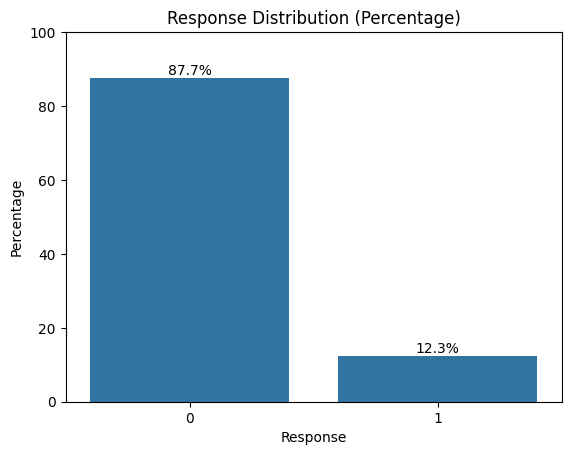

In [4]:
## Target distribution
# Calculate percentages
response_counts = train_df["Response"].value_counts()
response_percentages = response_counts / len(train_df) * 100

# Create the bar plot
ax = sns.barplot(x=response_percentages.index, y=response_percentages.values)

# Customize the y-axis to show percentages
ax.set_ylabel("Percentage")
ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100%

# Add percentage labels on top of each bar
for i, v in enumerate(response_percentages.values):
    ax.text(i, v, f"{v:.1f}%", ha='center', va='bottom')

plt.title("Response Distribution (Percentage)")
plt.show()

## EDA

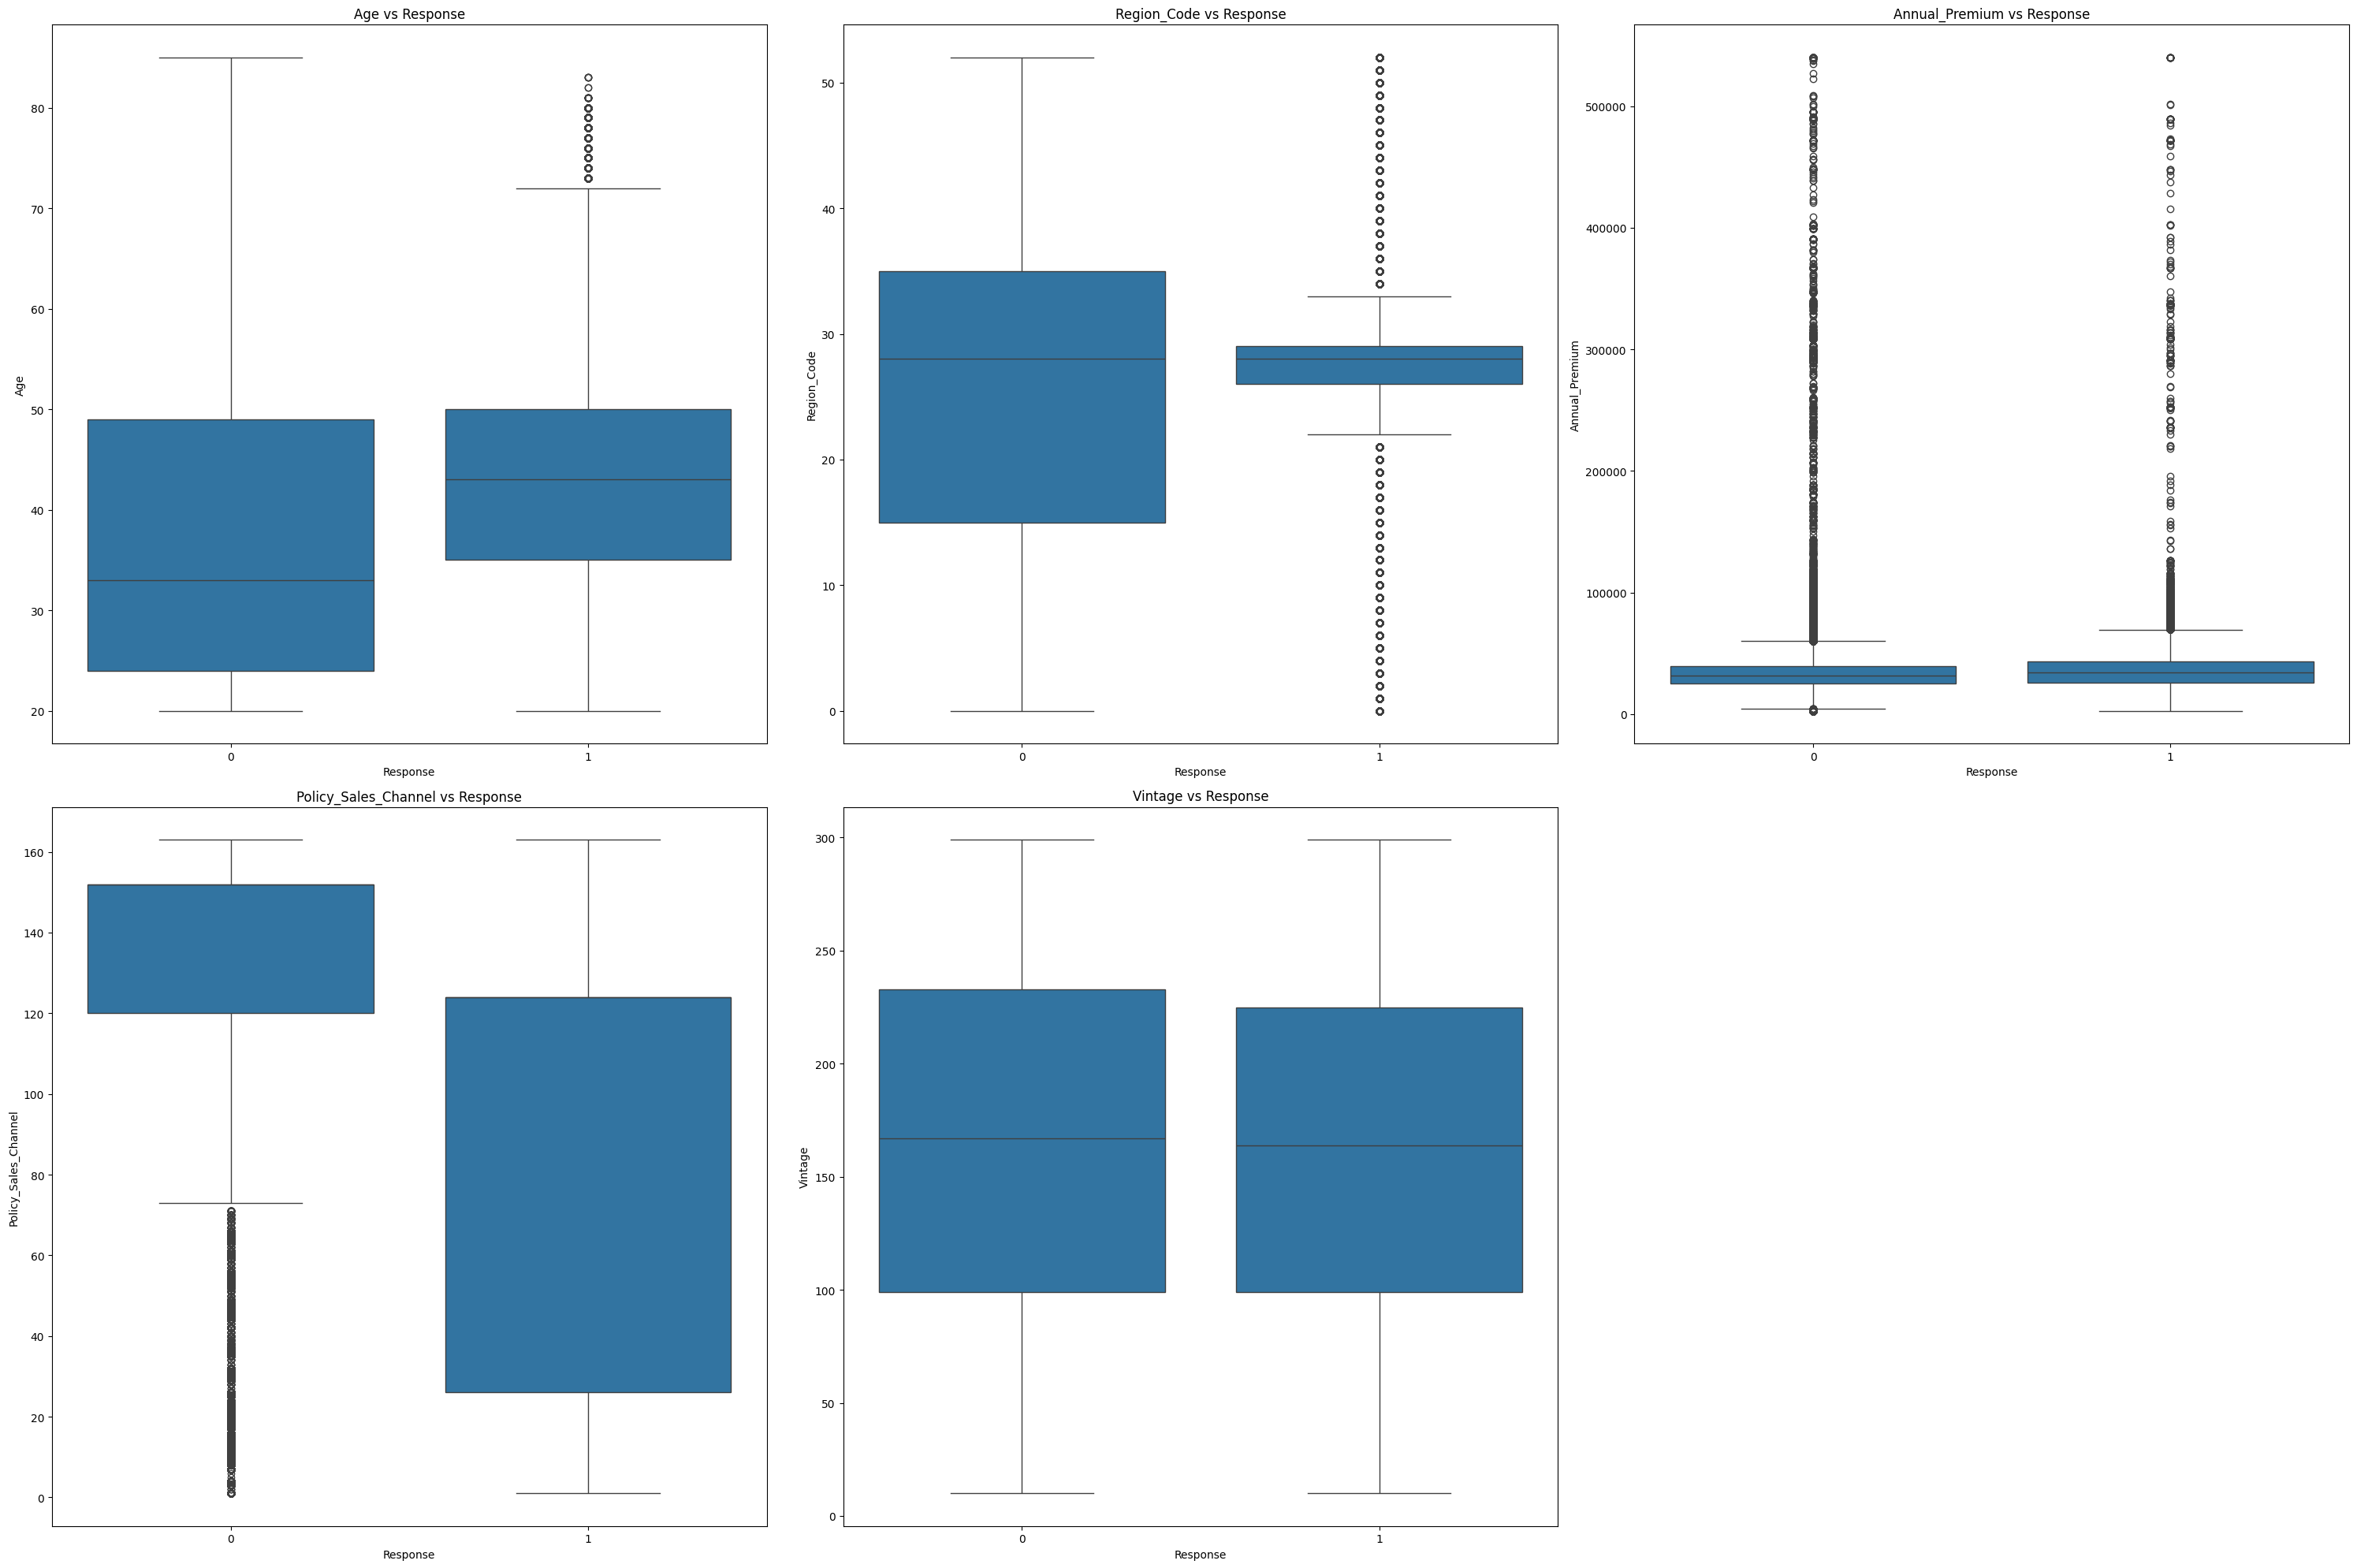

In [5]:
# See Response vs Continuos Columns
def plot_boxplots(df, response_col, cols, figsize=(30, 20)):
    n_cols = 3
    n_rows = (len(cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, cols):
        sns.boxplot(x=response_col, y=col, data=df, ax=ax)
        ax.set_title(f'{col} vs {response_col}')
        ax.set_xlabel(response_col)
        ax.set_ylabel(col)

    # Remove any unused subplots
    for ax in axes[len(cols):]:
        ax.remove()

    plt.tight_layout()
    return fig

# Usage
fig = plot_boxplots(train_df, 'Response', config["raw_data"]["continuous_cols"])
plt.show()

<Axes: >

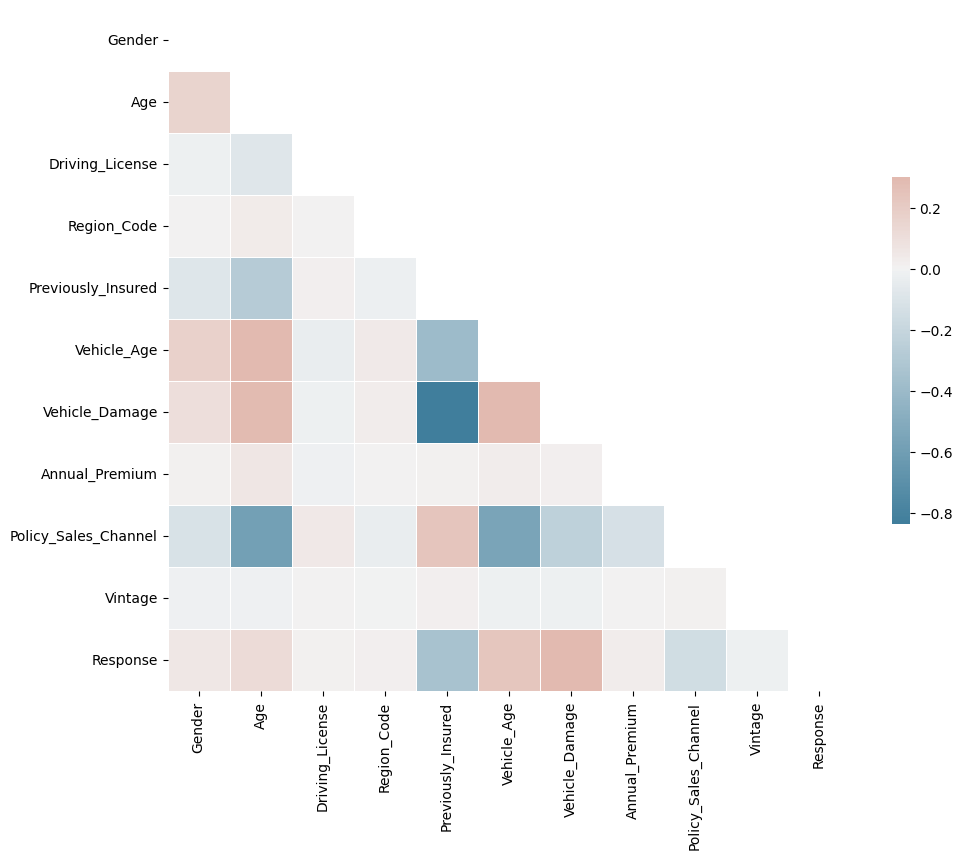

In [6]:
# Compute the correlation matrix
corr = train_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Features Engineer

In [ ]:
df['Previously_Insured_Annual_Premium'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Annual_Premium'].astype(str)))[0]
df['Previously_Insured_Vehicle_Age'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Age'].astype(str)))[0]
df['Previously_Insured_Vehicle_Damage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vehicle_Damage'].astype(str)))[0]
df['Previously_Insured_Vintage'] = pd.factorize((df['Previously_Insured'].astype(str) + df['Vintage'].astype(str)))[0]

## Modeling

### Baseline Model

In [8]:
# Baseline model using Logistic Regression CV (Before Feature Engineering)
X = train_df[config['feature_cols']]
y = train_df[config['target_cols']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)
y_pred = model.predict(X_test)

target_names = ['REJECT', 'MONEY MONEY MONEY']
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

           REJECT       0.88      1.00      0.93   2522560
MONEY MONEY MONEY       0.41      0.01      0.02    353640

         accuracy                           0.88   2876200
        macro avg       0.64      0.50      0.48   2876200
     weighted avg       0.82      0.88      0.82   2876200



<Axes: ylabel='Feature'>

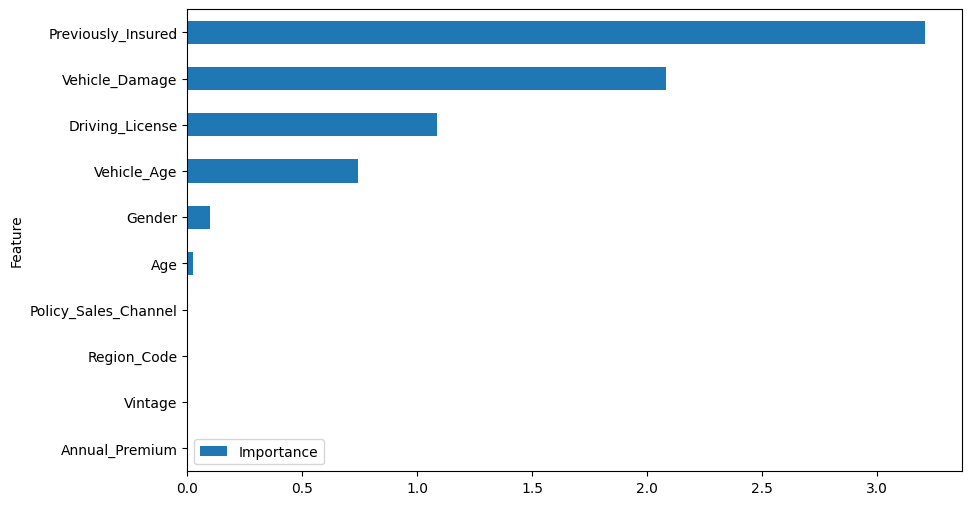

In [9]:
# To see the Feature Importance
coefficients = model.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

#### Baseline Model Performance

The baseline model achieves an overall accuracy of **0.88**.

##### Precision
- **REJECT**: 0.88 (88%)
- **MONEY MONEY MONEY**: 0.41 (41%)

The model is effective at predicting the "REJECT" class but struggles with "MONEY MONEY MONEY".

##### Recall
- **REJECT**: 1.00 (100%)
- **MONEY MONEY MONEY**: 0.01 (1%)

The recall for "REJECT" is perfect, indicating strong performance for this class. However, the model fails to detect the "MONEY MONEY MONEY" class, as shown by the extremely low recall.

##### F1-Score
- **REJECT**: 0.93
- **MONEY MONEY MONEY**: 0.02

The low F1-score for "MONEY MONEY MONEY" indicates poor performance in predicting this class.

#### Conclusion
- The model effectively predicts the majority "REJECT" class but performs poorly for the minority "MONEY MONEY MONEY" class.
- The high accuracy is mainly due to the class imbalance.
- Consider techniques like resampling, adjusting class weights, or exploring models better suited for imbalanced data to improve performance on the minority class.
- Potentially remove Policy_Sales_Channel, Region_Code, Vintage, and Annual_Premium. Dropping these features might simplify the model

### Exploration

In [28]:
# Model remove un important features based on Feature Importance values
X = train_df[config['feature_cols']].drop(['Policy_Sales_Channel', 'Region_Code', 'Vintage', 'Annual_Premium'], axis=1)
y = train_df[config['target_cols']]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Model Fit
model_drop = LogisticRegressionCV(cv=5, random_state=42).fit(X_train, y_train)

# Predict probabilities for the positive class (assumed to be the second column)
y_prob = model_drop.predict_proba(X_test)[:, 1]

# Find the best threshold for F1 score (you can change this to precision, recall, etc.)
best_threshold, best_f1 = find_best_threshold(y_test, y_prob, metric=f1_score)

# Apply the best threshold to create final predictions
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)

# Print the classification report
target_names = ['REJECT', 'MONEY MONEY MONEY']
print(f"Best threshold: {best_threshold:.2f}, Best F1 score: {best_f1:.4f}")
print(classification_report(y_test, y_pred_best_threshold, target_names=target_names))

Best threshold: 0.22, Best F1 score: 0.4390
                   precision    recall  f1-score   support

           REJECT       0.96      0.76      0.85   2522560
MONEY MONEY MONEY       0.31      0.77      0.44    353640

         accuracy                           0.76   2876200
        macro avg       0.63      0.76      0.64   2876200
     weighted avg       0.88      0.76      0.80   2876200



The overall accuracy is not impacted by dropping the features, but the "Money" label experienced a significant decline. However, the training time decreased significantly, by a factor of 7.

In [29]:
# Undersample the train data 
under_sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# Modelling & Predict
model_under_sample = LogisticRegressionCV(cv=5, random_state=42).fit(X_train_resampled, y_train_resampled)
y_prob = model_under_sample.predict_proba(X_test)[:, 1]
best_threshold, best_f1 = find_best_threshold(y_test, y_prob, metric=f1_score)
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)

# Print the classification report
target_names = ['REJECT', 'MONEY MONEY MONEY']
print(f"Best threshold: {best_threshold:.2f}, Best F1 score: {best_f1:.4f}")
print(classification_report(y_test, y_pred_best_threshold, target_names=target_names))

Best threshold: 0.67, Best F1 score: 0.4391
                   precision    recall  f1-score   support

           REJECT       0.96      0.76      0.85   2522560
MONEY MONEY MONEY       0.31      0.77      0.44    353640

         accuracy                           0.76   2876200
        macro avg       0.63      0.76      0.64   2876200
     weighted avg       0.88      0.76      0.80   2876200



The F1 score remains the same, but the chosen threshold appears more stable compared to when undersampling is not applied.

In [39]:
# Oversample the train data
over_sampler = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# Modelling & Predict
model_over_sample = LogisticRegressionCV(cv=5, random_state=42).fit(X_train_resampled, y_train_resampled)
y_prob = model_over_sample.predict_proba(X_test)[:, 1]
best_threshold, best_f1 = find_best_threshold(y_test, y_prob, metric=f1_score)
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)

# Print the classification report
target_names = ['REJECT', 'MONEY MONEY MONEY']
print(f"Best threshold: {best_threshold:.2f}, Best F1 score: {best_f1:.4f}")
print(classification_report(y_test, y_pred_best_threshold, target_names=target_names))

Best threshold: 0.68, Best F1 score: 0.4395
                   precision    recall  f1-score   support

           REJECT       0.96      0.75      0.84   2522560
MONEY MONEY MONEY       0.31      0.78      0.44    353640

         accuracy                           0.76   2876200
        macro avg       0.63      0.77      0.64   2876200
     weighted avg       0.88      0.76      0.79   2876200



The F1 score remain the same, but the time to compute increase compare to the baseline model.

## Advance Model

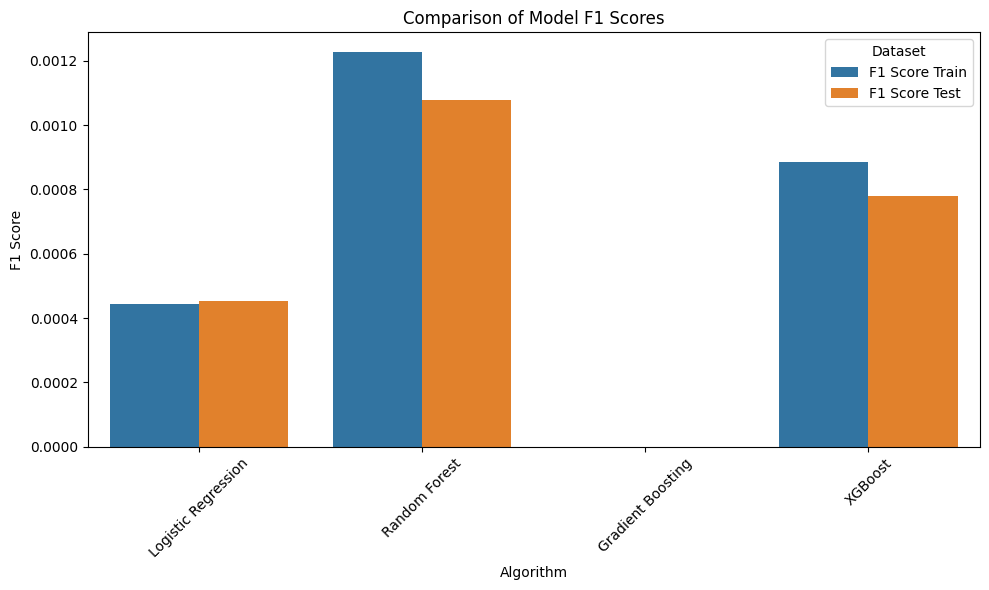

In [49]:
# Search advance performing model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# List of models to 
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boosting', GradientBoostingClassifier()),
    ('XGBoost', XGBClassifier())
]

# Initialize an empty list to store results
results = []

# Loop through each model
for model_name, model in models:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    results.append({
        'Algorithm': model_name,
        'F1 Score Train': f1_train,
        'F1 Score Test': f1_test
    })

# Create a DataFrame from the results
df_models = pd.DataFrame(results)

# Melt the DataFrame for visualization
df_melted = df_models.melt(id_vars='Algorithm', var_name='Dataset', value_name='F1 Score')

# Plot the F1 scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='F1 Score', hue='Dataset', data=df_melted)
plt.title('Comparison of Model F1 Scores')
plt.ylabel('F1 Score')
plt.xlabel('Algorithm')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [76]:
# Use Optuna to search for local best (Model: Xgboost)
def objective(trial):
    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
        trial (Trial): An Optuna trial object for parameter suggestion.

    Returns:
        float: Mean cross-validated F1 score.
    """
    # Hyperparameter space
    params = {
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.02),
        'n_estimators': trial.suggest_int('n_estimators', 5, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 17),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 42,
    }

    # Model instantiation
    model = XGBClassifier(**params)

    # Cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Scoring metric
    scoring = make_scorer(f1_score)

    # Cross-validation
    scores = cross_val_score(model, X_train_resampled, y_train_resampled, scoring=scoring, cv=cv)

    return np.min([np.mean(scores), np.median([scores])])

In [77]:
# --Run the function
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Under-sample the training data
under_sampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = under_sampler.fit_resample(X_train, y_train)

# Create the study
study = optuna.create_study(study_name='optimization', direction='maximize')

# Optimize the study
study.optimize(objective, n_trials=50)

[I 2024-09-14 23:16:18,280] A new study created in memory with name: optimization
[I 2024-09-14 23:16:40,038] Trial 0 finished with value: 0.8220793036722153 and parameters: {'lambda': 0.39451422436282224, 'alpha': 0.6531185760794016, 'colsample_bytree': 0.3612254494956263, 'subsample': 0.6378069712041816, 'learning_rate': 0.01748019551939055, 'n_estimators': 69, 'max_depth': 7, 'min_child_weight': 30}. Best is trial 0 with value: 0.8220793036722153.
[I 2024-09-14 23:23:31,420] Trial 1 finished with value: 0.8222606874300894 and parameters: {'lambda': 1.3388704880722793, 'alpha': 0.011915575375714622, 'colsample_bytree': 0.6775828661771297, 'subsample': 0.8362044006319003, 'learning_rate': 0.011271967013255994, 'n_estimators': 876, 'max_depth': 16, 'min_child_weight': 170}. Best is trial 1 with value: 0.8222606874300894.
[I 2024-09-14 23:26:56,999] Trial 2 finished with value: 0.8223257614353974 and parameters: {'lambda': 0.004029994424029792, 'alpha': 1.00774526618302, 'colsample_bytr

In [80]:
# Best Model
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(alpha=0.007511647670094584, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.809956948537315, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.11204782004357591,
              learning_rate=0.008754322345519566, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=94, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=18, n_jobs=None, ...)

In [81]:
# Metric of the best model
y_prob = best_model.predict_proba(X_test)[:, 1]
best_threshold, best_f1 = find_best_threshold(y_test, y_prob, metric=f1_score)
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)

# Print the classification report
target_names = ['REJECT', 'MONEY MONEY MONEY']
print(f"Best threshold: {best_threshold:.2f}, Best F1 score: {best_f1:.4f}")
print(classification_report(y_test, y_pred_best_threshold, target_names=target_names))

Best threshold: 0.52, Best F1 score: 0.4462
                   precision    recall  f1-score   support

           REJECT       0.97      0.72      0.83   2522560
MONEY MONEY MONEY       0.30      0.85      0.45    353640

         accuracy                           0.74   2876200
        macro avg       0.64      0.79      0.64   2876200
     weighted avg       0.89      0.74      0.78   2876200



The current best model already accounts for the imbalanced dataset. Although this approach decreased the overall accuracy from 88% to 74%, the recall on the "money" label increased significantly, boosting its F1 score. Additionally, some features were dropped to reduce the computation cost during model optimization. The current model can still be improved.

Potential improvements include performing feature engineering or using all the columns in a more advanced model that can capture more information.

---